# Hybrid attack

### Load results 

In [2]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from itertools import product

# parameters 
dataset_names = ['cora', 'polblogs']
graph1_props = [0.0]
common_props = [0]
sns.set(font_scale=1.2)
sns.set_theme(style="whitegrid")

graph_statistics = {
    "acm" : {
        "nodes": 3025,
        "edges": 13128,
    },
    "polblogs" : {
        "nodes": 1222,
        "edges": 16714,
    },
    "flickr" : {
        "nodes": 7575,
        "edges": 239738,
    },
    "cora" : {
        "nodes": 2485,
        "edges": 5069,
    },
    "block" : {
        "nodes": 3346,
        "edges": 54901,
    },

    "bio-diseasome" : {
        "nodes": 516,
        "edges": 1188,
    },
    
}

results = {}

erdos_results = {
    "polblogs": (16713, 0, 730537, 1),
    "cora": (5053, 17, 3083767, 16),
    "flickr": 24546,
    "acm": (12970, 22, 4563645, 158),
    "block": (10756, 36678, 2760575, 43935),
    "bio-diseasome": (1182, 10, 132188, 6),

}

### RAE - G1 = 0

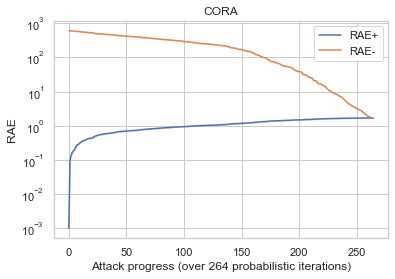

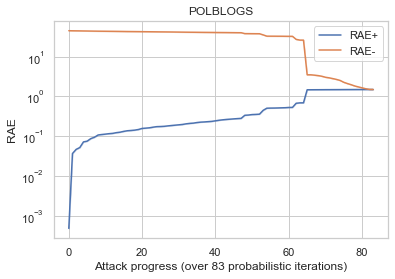

In [22]:
# Plot results
for dataset_name in dataset_names:
    current_results = results[dataset_name]
    for j, (graph1_prop, common_prop) in enumerate(product(graph1_props, common_props)):
        #  results = pd.read_csv(f"logs_hybrid/{dataset_name}_preferential_attachment_A.csv", header=None)
        #  results.columns = ['run', 'attack_type','graph1_prop', 'common_prop', 'iter_num', 'absent', 'present', 'unknown', 'TP', 'FP', 'TN', 'FN', 'time']

        
        current_results = current_results[(current_results['graph1_prop'] == graph1_prop) & (current_results['common_prop'] == common_prop) & (current_results['attack_type'] == 'probabilistic')].copy()
        number_probabilistics = current_results["iter_num"].max()

        current_results.loc[:, "progress"] = (current_results.loc[:, "iter_num"] / current_results.loc[:,"iter_num"].max()).astype(float)

        # print(current_results)

        rae_plus = ((current_results["FP"] + current_results["FN"]) /  graph_statistics[dataset_name]["edges"]).astype(float)
        rae_minus = (( (current_results["FP"] + current_results["FN"] ) + current_results["unknown"] ) / graph_statistics[dataset_name]["edges"]).astype(float)
        
        current_results["rae_plus"] = rae_plus
        current_results["rae_minus"] = rae_minus


        sns.lineplot(x='iter_num', y='rae_plus', data=current_results, label=f'RAE+')
        sns.lineplot(x=current_results["iter_num"], y=current_results['rae_minus'], label=f'RAE-')
        plt.xlabel(f'Attack progress (over {number_probabilistics} probabilistic iterations)')
        plt.ylabel('RAE')
        plt.yscale("log") 
        plt.title(f'{dataset_name.upper()}')
        plt.legend()
        plt.show()


## Proportion of identified edges

## Accuracy (number of slots correctly filled in the adjacency matrix)

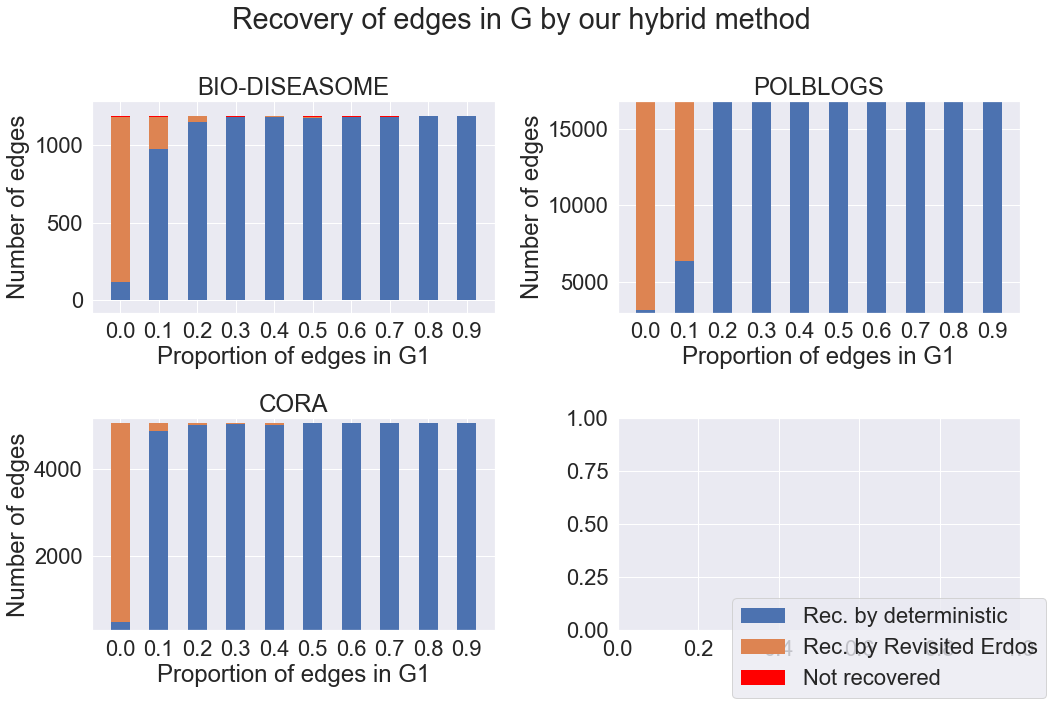

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid")
sns.set(font_scale=2)  # crazy big

dataset_names = ['bio-diseasome', 'polblogs', 'cora']
fig, axes = plt.subplots(2 , 2, figsize=(15, 10))
graph1_props = [0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for i, dataset_name in enumerate(dataset_names):
    data = pd.read_csv(f"logs_erdos/{dataset_name}.csv", header=None)
    data.columns = ['run', 'attack_type','graph1_prop', 'common_prop', 'iter_num', 'absent', 'present', 'unknown', 'TP', 'FP', 'TN', 'FN', 'time']

    results =  []

    for prop in graph1_props:
        last_deterministic = data[(data['graph1_prop'] == prop) & (data['common_prop'] == 0) & (data['attack_type'] == 'deterministic')].tail(1)
        erdos = data[(data['graph1_prop'] == prop) & (data['common_prop'] == 0) & (data['attack_type'] == 'erdos')]

        if len(erdos) == 0:
            results.append((last_deterministic["TP"].values[0], 0, 0))
        else:
            erdos = erdos.tail(1)
            deterministic = last_deterministic["TP"].values[0]
            r_erdos = erdos["TP"].values[0] - last_deterministic["TP"].values[0]
            missing = graph_statistics[dataset_name]["edges"] - erdos["TP"].values[0]
            results.append((deterministic, r_erdos, missing))

    results = np.array(results)

    bar_width = 0.05
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    ax.bar(graph1_props, results[:, 0], width=bar_width, label='Rec. by deterministic' if i == 0 else "", edgecolor='none')
    ax.bar(graph1_props, results[:, 1], width=bar_width, bottom=results[:, 0], label='Rec. by Revisited Erdos' if i == 0 else "", edgecolor='none')
    ax.bar(graph1_props, results[:, 2], width=bar_width, bottom=results[:, 0] + results[:, 1], label='Not recovered' if i == 0 else "", edgecolor='none', color='red')

    ax.set_ylim(min(results[:, 0]) - 200, graph_statistics[dataset_name]["edges"] + 100)
    ax.set_title(f'{dataset_name.upper()}')
    ax.set_xlabel('Proportion of edges in G1')
    ax.set_ylabel('Number of edges')
    ax.set_xticks(graph1_props)  # Set the x-axis ticks to match the positions
    

plt.suptitle('Recovery of edges in G by our hybrid method')
plt.tight_layout()
fig.legend(loc="lower right")
fig.subplots_adjust(top=0.85)
plt.show()





# RAE - G1 empty - Comparision with Erdos et al.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


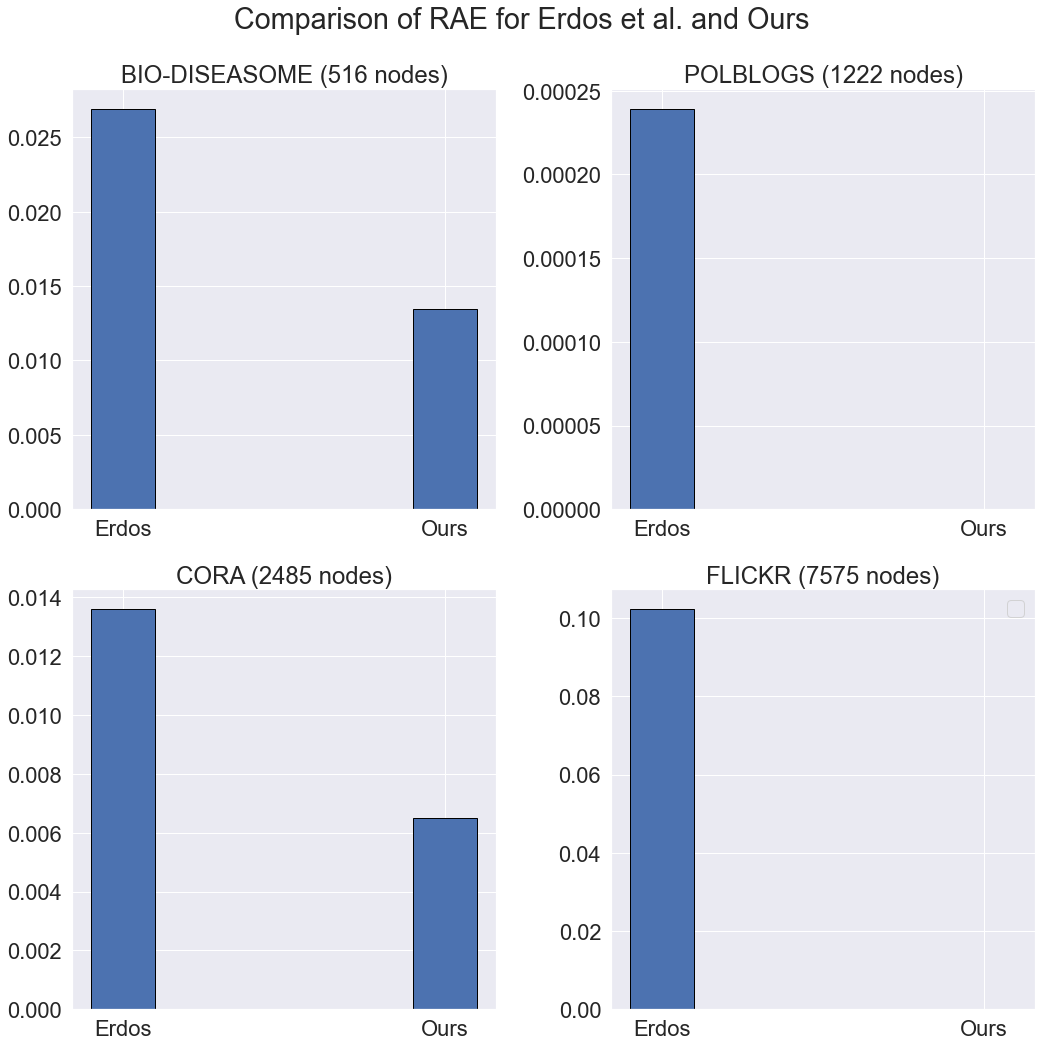

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dataset_names = ['bio-diseasome', 'polblogs', 'cora', 'flickr']

fig, axes = plt.subplots(2 , int(len(dataset_names) / 2), figsize=(15, 15))


for i, dataset_name in enumerate(dataset_names):
    data = pd.read_csv(f"logs_erdos/{dataset_name}.csv", header=None)
    data.columns = ['run', 'attack_type','graph1_prop', 'common_prop', 'iter_num', 'absent', 'present', 'unknown', 'TP', 'FP', 'TN', 'FN', 'time']

    results =  []

    last_deterministic = data[(data['graph1_prop'] == 0) & (data['common_prop'] == 0) & (data['attack_type'] == 'deterministic')].tail(1)
    erdos = data[(data['graph1_prop'] == 0) & (data['common_prop'] == 0) & (data['attack_type'] == 'erdos')]

    erdos_result = erdos_errors[dataset_name] / graph_statistics[dataset_name]["edges"]
    if len(erdos) == 0:
        ours = (last_deterministic["FP"].values[0] + last_deterministic["FN"].values[0]) / graph_statistics[dataset_name]["edges"]
    else:
        erdos = erdos.tail(1)
        ours = (erdos["FP"].values[0] + erdos["FN"].values[0])/ graph_statistics[dataset_name]["edges"]

    row = i // 2
    col = i % 2
    ax = axes[row, col]
    nodes = graph_statistics[dataset_name]["nodes"]
    ax.bar(["Erdos", "Ours"], [erdos_result, ours], width=0.2, edgecolor='black')
    ax.set_title(f'{dataset_name.upper()} ({nodes} nodes)')
    # ax.set_yticks(np.arange(0, 0.1, 0.01))
    # ax.set_ylabel('RAE')
    
fig.suptitle('Comparison of RAE for Erdos et al. and Ours')
fig.tight_layout()
plt.legend()
plt.show()





# Precision - G1 empty - Comparision with Erdos et al.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


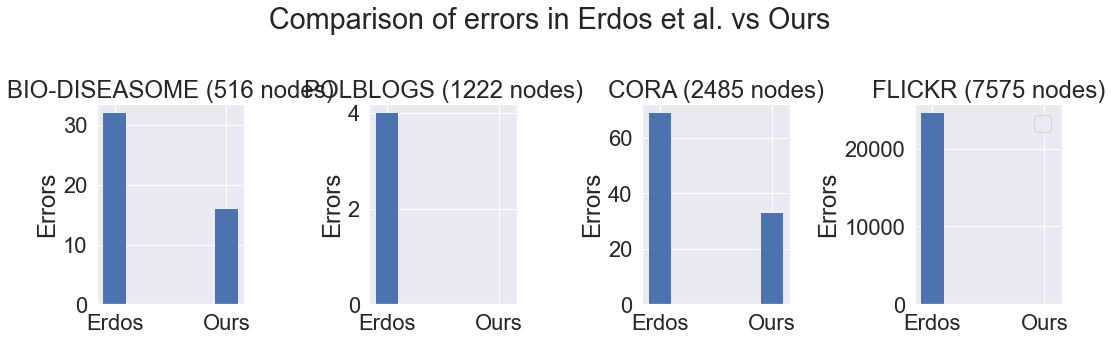

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dataset_names = ['bio-diseasome', 'polblogs', 'cora', 'flickr']

fig, axes = plt.subplots(1 , len(dataset_names), figsize=(15, 5))


for i, dataset_name in enumerate(dataset_names):
    data = pd.read_csv(f"logs_erdos/{dataset_name}.csv", header=None)
    data.columns = ['run', 'attack_type','graph1_prop', 'common_prop', 'iter_num', 'absent', 'present', 'unknown', 'TP', 'FP', 'TN', 'FN', 'time']

    results =  []

    last_deterministic = data[(data['graph1_prop'] == 0) & (data['common_prop'] == 0) & (data['attack_type'] == 'deterministic')].tail(1)
    erdos = data[(data['graph1_prop'] == 0) & (data['common_prop'] == 0) & (data['attack_type'] == 'erdos')]

    erdos_result = erdos_errors[dataset_name]
    if len(erdos) == 0:
        ours = last_deterministic["TP"].values[0] / (last_deterministic["FN"].values[0] + last_deterministic["TP"].values[0])
    else:
        erdos = erdos.tail(1)
        ours = erdos["TP"].values[0] / (erdos["TP"] + erdos["FN"].values[0])

    
    ax = axes[i]
    ax.bar(["Erdos", "Ours"], [erdos_result, ours], width=0.2, edgecolor='none')
    nodes = graph_statistics[dataset_name]["nodes"]
    ax.set_title(f'{dataset_name.upper()} ({nodes} nodes)')
    ax.set_ylabel('Errors')
    

fig.suptitle("Comparison of errors in Erdos et al. vs Ours")
plt.legend()
fig.tight_layout()

plt.show()



